In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

print(f'GPUs Available: {len(tf.config.list_physical_devices("GPU"))}')

GPUs Available: 1


In [6]:
normal = pd.read_hdf('./data/training_normal.h5')
faulty = pd.read_hdf('./data/training_faulty.h5')
mean = pd.read_hdf('./data/norm.h5', key='mean')
std = pd.read_hdf('./data/norm.h5', key='std')

normal_data = normal.iloc[:, 3:]
normalized_data = (normal_data - mean) / std
normalized_data.head()

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,-0.003307,0.300364,0.514599,-1.342731,-0.062398,0.294726,-0.098047,-0.252914,0.522186,0.089759,...,-0.489006,0.005770,1.001362,-0.150228,-0.078897,1.424527,0.520011,-0.165134,0.284191,0.224294
1,0.019690,-0.128967,1.218404,0.925080,-0.856779,1.091016,-0.005032,-0.000158,0.522186,-0.068269,...,-1.191637,-0.016944,-1.639727,-0.250199,0.078954,0.153478,-1.208816,-0.195688,0.470946,-0.631769
2,-0.003307,-0.102502,-0.791010,1.114064,-0.128596,-1.224631,0.154424,-0.422647,1.045513,-0.113762,...,0.816185,0.008733,-0.018895,0.308127,0.123493,0.300513,0.070048,-0.180595,0.175097,1.647422
3,-0.023065,-0.073095,0.083646,1.522363,-0.681826,-1.256665,0.287304,0.413106,-0.524468,-0.121743,...,-0.058910,0.028155,-1.159749,0.113845,0.132008,-0.009071,0.428147,-0.110653,0.996077,-0.020296
4,1.411175,0.447396,-0.301407,-0.105001,-0.062398,1.429668,0.008256,0.715675,-0.524468,-0.856811,...,-0.672116,1.368624,-0.467518,-0.508613,-0.596991,1.300424,0.472378,-0.225506,0.744606,0.233859


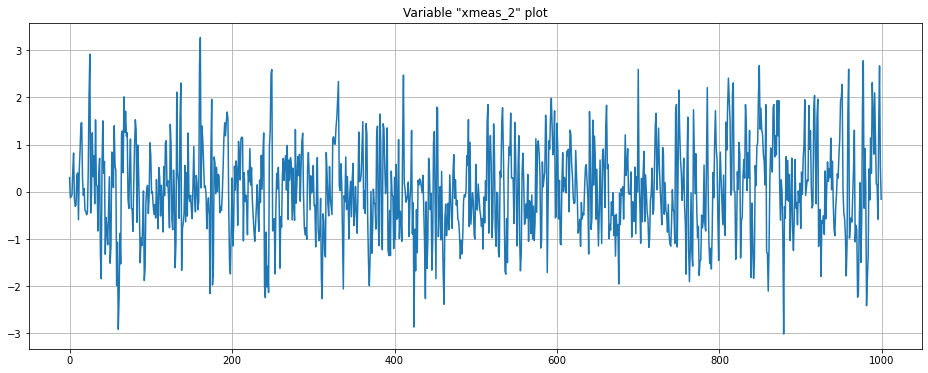

In [7]:
variable = 'xmeas_2'

plt.figure(figsize=(16, 6))
plt.grid()
plt.plot(normalized_data.index[:1000], normalized_data[variable][:1000])
plt.title(f'Variable "{variable}" plot')
plt.show()

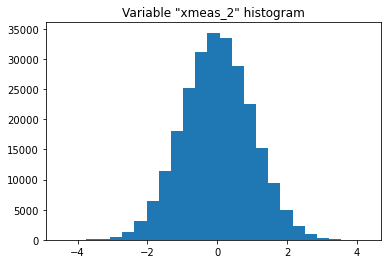

In [8]:
plt.hist(normalized_data[variable], bins=25)
plt.title(f'Variable "{variable}" histogram')
plt.show()

## LSTM Autoencoder model

In [9]:
def to_sequences(x, y, seq_size=10):
    x_seq, y_seq = [], []
    for i in range(len(x)-seq_size):
        x_seq.append(x.iloc[i:i+seq_size].values)
        y_seq.append(y.iloc[i+seq_size])
    return np.array(x_seq), np.array(y_seq)
        
x, y = to_sequences(normalized_data, normalized_data)

In [10]:
train_data, valid_data = train_test_split(x, test_size=0.2, shuffle=False)
print(f'train data size: {train_data.shape}')
print(f'valid data size: {valid_data.shape}')

input_dims =  train_data.shape

train_data = tf.cast(train_data, tf.float32)
valid_data = tf.cast(valid_data, tf.float32)

train data size: (199992, 10, 52)
valid data size: (49998, 10, 52)


In [11]:
class LSTMAutoencoder(Model):
    def __init__(self, input_dims):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.LSTM(128, return_sequences=True, input_shape=(input_dims[1], input_dims[2])),
            layers.LSTM(32, return_sequences=False)
        ])

        self.decoder = tf.keras.Sequential([
            layers.RepeatVector(input_dims[1]),
            layers.LSTM(32, return_sequences=True),
            layers.LSTM(128, return_sequences=True),
            layers.TimeDistributed(layers.Dense(input_dims[2]))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = LSTMAutoencoder(input_dims)

In [12]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.005), 
              loss=tf.losses.MeanSquaredError(), 
              metrics=[tf.metrics.MeanAbsoluteError()])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.5, 
                                                 patience=5, 
                                                 min_lr=0.0001,
                                                 verbose=1)

In [ ]:
history = model.fit(train_data, train_data, 
                    epochs=150, 
                    batch_size=256, 
                    validation_data=(valid_data, valid_data), 
                    shuffle=True, 
                    callbacks=[reduce_lr])

Epoch 1/150
782/782 [==============================] - 24s 15ms/step - loss: 0.5896 - mean_absolute_error: 0.5783 - val_loss: 0.5368 - val_mean_absolute_error: 0.5438
Epoch 2/150
782/782 [==============================] - 10s 12ms/step - loss: 0.5285 - mean_absolute_error: 0.5381 - val_loss: 0.5258 - val_mean_absolute_error: 0.5352
Epoch 3/150
782/782 [==============================] - 9s 11ms/step - loss: 0.5222 - mean_absolute_error: 0.5323 - val_loss: 0.5216 - val_mean_absolute_error: 0.5311
Epoch 4/150
782/782 [==============================] - 9s 11ms/step - loss: 0.5203 - mean_absolute_error: 0.5303 - val_loss: 0.5209 - val_mean_absolute_error: 0.5308
Epoch 5/150
782/782 [==============================] - 9s 11ms/step - loss: 0.5167 - mean_absolute_error: 0.5259 - val_loss: 0.5129 - val_mean_absolute_error: 0.5204
Epoch 6/150
782/782 [==============================] - 9s 12ms/step - loss: 0.5129 - mean_absolute_error: 0.5208 - val_loss: 0.5196 - val_mean_absolute_error: 0.5265
Ep

782/782 [==============================] - 9s 12ms/step - loss: 0.4976 - mean_absolute_error: 0.5030 - val_loss: 0.4993 - val_mean_absolute_error: 0.5042
Epoch 50/150
782/782 [==============================] - 9s 12ms/step - loss: 0.4974 - mean_absolute_error: 0.5027 - val_loss: 0.4991 - val_mean_absolute_error: 0.5039
Epoch 51/150
782/782 [==============================] - 9s 12ms/step - loss: 0.4972 - mean_absolute_error: 0.5026 - val_loss: 0.4991 - val_mean_absolute_error: 0.5039
Epoch 52/150
782/782 [==============================] - 9s 12ms/step - loss: 0.4980 - mean_absolute_error: 0.5035 - val_loss: 0.4999 - val_mean_absolute_error: 0.5051
Epoch 53/150
782/782 [==============================] - 9s 12ms/step - loss: 0.4975 - mean_absolute_error: 0.5030 - val_loss: 0.4992 - val_mean_absolute_error: 0.5040
Epoch 54/150
782/782 [==============================] - 9s 12ms/step - loss: 0.4976 - mean_absolute_error: 0.5031 - val_loss: 0.4995 - val_mean_absolute_error: 0.5043
Epoch 55/15

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('L2 Loss')
plt.legend()

## Save model

In [ ]:
# Save model
model.save('saved_model/ae_loss_0967')

## Load model

In [ ]:
# Load model
model = tf.keras.models.load_model('saved_model/ae_loss_0967')

# Evaluate the restored model
mse, mae = model.evaluate(train_data, train_data, batch_size=200000, verbose=2)
print('Restored model, train MSE: {:.4f}'.format(mse))
print()
mse, mae = model.evaluate(valid_data, valid_data, batch_size=50000, verbose=2)
print('Restored model, valid MSE: {:.4f}'.format(mse))

In [ ]:
reconstructions = model.predict(train_data)
train_loss = tf.keras.losses.mse(reconstructions, train_data)
print(train_loss.shape)
# plt.hist(train_loss[None,:], bins=50)
# plt.xlabel("L2 Loss")
# plt.ylabel("Samples")
# plt.show()

In [ ]:
encoded_data = model.encoder(train_data)
print(encoded.data.shape)

In [ ]:
faultNumber, simulationRun = 3, 324

faulty_data = faulty[
    (faulty['faultNumber'] == faultNumber) & 
    (faulty['simulationRun'] == simulationRun) &
    (faulty['sample'] > 20)
].iloc[:, 3:]

faulty_data = (faulty_data - mean) / std
faulty_data = tf.cast(faulty_data.values, tf.float32)

# Normal data
encoded_data = model.encoder(train_data).numpy()
decoded_data = model.decoder(encoded_data).numpy()

# Faulty data
encoded_faulty_data = model.encoder(faulty_data).numpy()
decoded_faulty_data = model.decoder(encoded_faulty_data).numpy()

fig, axs = plt.subplots(3, 2, figsize=(16, 40))

for row, sample in enumerate(np.sort(np.random.randint(20, 480, size=3))):
    normal_abs_diff = np.abs(train_data[sample] - decoded_data[sample])
    faulty_abs_diff = np.abs(faulty_data[sample] - decoded_faulty_data[sample])
    for col in range(2):
        if col == 0:
            loss = tf.keras.losses.mse(train_data[sample], decoded_data[sample]).numpy()
            axs[row, col].barh(normalized_data.columns, normal_abs_diff)
            axs[row, col].set_title(f'Normal Data, sample {sample}, mse = {round(loss, 3)}')
        else:
            loss = tf.keras.losses.mse(faulty_data[sample], decoded_faulty_data[sample]).numpy()
            axs[row, col].barh(normalized_data.columns, faulty_abs_diff)
            axs[row, col].set_title(f'Fault #{faultNumber} Data, sample {sample}, mse = {round(loss, 3)}')
        
        axs[row, col].set_xlim((0, np.max([normal_abs_diff, faulty_abs_diff])))
        axs[row, col].invert_yaxis()
        axs[row, col].margins(y=0)
    
for ax in axs.flat:
    ax.set(xlabel='Absolute Error', ylabel='Features')
    
fig.tight_layout()
plt.show()

In [ ]:
# Run model for normal and faulty simulation 
# Train data
reconstructions = model.predict(train_data)
train_loss = tf.keras.losses.mse(reconstructions, train_data)

# Valid data
valid_reconstructions = model.predict(valid_data)
valid_loss = tf.keras.losses.mse(valid_reconstructions, valid_data)

# Fault data
faulty_data = faulty[faulty['sample'] > 20].iloc[:, 3:].sample(n=250000)
faulty_data = (faulty_data - mean) / std
faulty_data = tf.cast(faulty_data.values, tf.float32)
faulty_reconstructions = model.predict(faulty_data)
faulty_loss = tf.keras.losses.mse(faulty_reconstructions, faulty_data)

# Reconstruction error plot
fig, axs = plt.subplots(2, 1, figsize=(16, 12))

axs[0].scatter(np.arange(200000), train_loss, s=5)
axs[0].scatter(np.arange(200001, 250001), valid_loss, color='g', s=5)
axs[0].set_title('Reconstruction error for normal data')
axs[0].grid()

axs[1].scatter(np.arange(faulty_loss.shape[0]), faulty_loss, color='r', s=5)
axs[1].set_title('Reconstruction error for faulty data')
axs[1].grid()

plt.show()

In [ ]:
fig, axs = plt.subplots(10, 2, figsize=(16, 24))

for i in range(0, 20):
    row, col = divmod(i, 2)
    
    # Run model for fault simulation
    faultNumber = i+1
    simulationRun = np.random.randint(500)

    faulty_data = faulty[(faulty['faultNumber'] == faultNumber) & (faulty['simulationRun'] == simulationRun)]
    faulty_data = (faulty_data.iloc[:, 3:] - mean) / std
    faulty_data = tf.cast(faulty_data.values, tf.float32)

    reconstructions = model.predict(faulty_data)
    loss = tf.keras.losses.mse(reconstructions, faulty_data)
    
    axs[row, col].grid()
    axs[row, col].plot(np.arange(500), loss)
    axs[row, col].set_title(f'Reconstruction for Fault {faultNumber}, Simulation {simulationRun}')
    axs[row, col].vlines([20], 0, np.max(loss), colors='r')
    
for ax in axs.flat:
    ax.set(xlabel='Sample', ylabel='L2 Loss')
    
fig.tight_layout()
plt.show()

## Detecting fault

In [ ]:
normal_data = normal.iloc[:, 3:]
faulty_data = faulty[
    (faulty['simulationRun'] <= 20) & 
    (faulty['sample'] > 20)
].iloc[:, 3:]

norm_normal_data = (normal_data - mean) / std
norm_faulty_data = (faulty_data - mean) / std

print(norm_normal_data.shape)
print(norm_faulty_data.shape)

In [ ]:
normal_encoded = model.encoder(norm_normal_data.values).numpy()
faulty_encoded = model.encoder(norm_faulty_data.values).numpy()

normal_encoded = pd.DataFrame(normal_encoded, columns=[f'enc_{num+1}' for num in range(normal_encoded.shape[1])])
faulty_encoded = pd.DataFrame(faulty_encoded, columns=[f'enc_{num+1}' for num in range(faulty_encoded.shape[1])])
normal_encoded['fault'] = 0.0
faulty_encoded['fault'] = 1.0

data = pd.concat([normal_encoded, faulty_encoded], ignore_index=True)
data = data.sample(n=20000)
print(data['fault'].value_counts())
display(data)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

clf = SVC(C=1.0, kernel='rbf', gamma='auto', verbose=True)
clf.fit(X, y)

In [ ]:
print(f'score: {clf.score(X, y)}')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(clf, X, y, display_labels=['Normal', 'Fault'], 
                      cmap=plt.cm.Blues, normalize=None, ax=ax);

In [ ]:
normal_samples = 500
normal_kpi = clf.decision_function(normal_encoded.iloc[:normal_samples, :-1].values)

In [ ]:
x = np.arange(normal_samples)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(x, np.tanh(normal_kpi))
ax.grid()
ax.axhline(color='black')
ax.fill_between(x, 0, -1, facecolor='green', alpha=0.1)
ax.fill_between(x, 0, 1, facecolor='red', alpha=0.1)
ax.margins(x=0, y=0.04)
ax.set_title('Normal data')
plt.show()

In [ ]:
faultNumber = 19
simulationRun = np.random.randint(0, 500)

f_data = faulty[
    (faulty['faultNumber'] == faultNumber) & 
    (faulty['simulationRun'] == simulationRun)
].iloc[:, 3:]

nf_data = (f_data - mean) / std
f_encoded = model.encoder(nf_data.values).numpy()
faulty_kpi = clf.decision_function(f_encoded)

In [ ]:
samples = 500
x = np.arange(samples)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(x, np.tanh(faulty_kpi))
ax.grid()
ax.axhline(color='black')
ax.fill_between(x, 0, -1, facecolor='green', alpha=0.1)
ax.fill_between(x, 0, 1, facecolor='red', alpha=0.1)
ax.vlines([20], -1, 1, colors='r')
ax.margins(x=0, y=0.04)
ax.set_title(f'Fault #{faultNumber} data (simulation run #{simulationRun})')
plt.show()